In [41]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import itk
from itkwidgets import view
from ipywidgets import interactive
import ipywidgets as widgets
import time as time_lib
from math import ceil

import OpenVisus as ov

# Enable I/O component of OpenVisus
ov.DbModule.attach();

In [2]:
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=borg")
# print(dataset.getDatasetBody().toString())
print('max resolution:', dataset.getMaxResolution())
print(dataset.getTimesteps().toString())

max resolution: 33
<DatasetTimesteps>
	<timestep from="0" to="15" step="1" />
</DatasetTimesteps>


In [6]:
#####
# 1 #
#####
# data = dataset.read(max_resolution=24, time=15)
# data.tofile('borg.raw')
# print(data.shape)

(144, 144, 144)


In [4]:
#####
# 2 #
#####

data = dataset.read(max_resolution=24, time=0)
image = itk.image_from_array(data)
viewer = view(image)

def show(resolution=24, time=15):
    data = dataset.read(max_resolution=resolution, time=time)
    viewer.image = itk.image_from_array(data)

slider = interactive(show, resolution=(15, 24, 3), time=(0, 15, 1), continuous_update=False)
widgets.VBox([viewer, slider])

In [5]:
data = dataset.read(max_resolution=24, time=15)

image = itk.image_from_array(data[:,:,10])
viewer = view(image)

def show(slice=0):
    viewer.image = itk.image_from_array(data[slice,:,:])

z_max = data.shape[2]
slider = interactive(show, slice=(0, z_max-1, 1), continuous_update=False)
widgets.VBox([viewer, slider])

In [18]:
#####
# 3 #
#####

def get_highest_point(data):
    highest = 0
    
    # scan down
    for z in range(data.shape[2]):
        slice = data[z,:,:]
        count = (slice == 0).sum()
        if count != slice.shape[0] * slice.shape[1]: break
        highest = z
    
    return highest


def get_lowest_point(data):
    lowest = 0
        
    # scan up
    for z in range(data.shape[2]-1, -1, -1):
        slice = data[z,:,:]
        count = (slice == 255).sum()
        if count != slice.shape[0] * slice.shape[1]: break
        lowest = z
    
    return lowest


def get_mixed_percent(data):
    highest = get_highest_point(data)
    lowest = get_lowest_point(data)

    thickness = lowest - highest + 1
    perc = thickness / data.shape[2]
    return perc


resolutions = [15, 18, 21, 24]
times = list(range(15))

all_ys = []
all_ys_times = []
for resolution in resolutions:
    start_time = time_lib.time()
    print(resolution, end=' ')
    ys = []
    for time in times:
        data = dataset.read(max_resolution=resolution, time=time)
        perc = get_mixed_percent(data)
        ys.append(perc)
    all_ys.append(ys)

    end_time = time_lib.time()
    elapsed_time = end_time - start_time
    all_ys_times.append(elapsed_time)
    print(elapsed_time, 'seconds')

15 9.217504978179932 seconds
18 5.932501792907715 seconds
21 7.203716993331909 seconds
24 17.425119876861572 seconds


In [7]:
data = dataset.read(max_resolution=24, time=0)
image = itk.image_from_array(data)
viewer = view(image)

def show(resolution=24, time=15):
    data = dataset.read(max_resolution=resolution, time=time)
    highest = get_highest_point(data)
    lowest = get_lowest_point(data)
    print('top:', highest)
    print('bottom:', lowest)
    print('thickness', lowest - highest + 1)
    print('mixed percent:', round((lowest - highest + 1) / data.shape[2], 2))
    data[highest,:,:] = 128
    data[lowest,:,:] = 250
    viewer.image = itk.image_from_array(data)

slider = interactive(show, resolution=(15, 24, 3), time=(0, 15, 1), continuous_update=False)
widgets.VBox([viewer, slider])

<IPython.core.display.Javascript object>


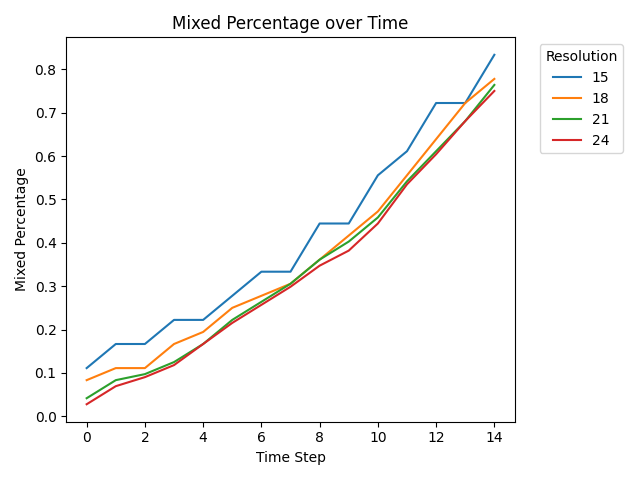

In [8]:
plt.figure()
for i,ys in enumerate(all_ys):
    plt.plot(times, ys, label=resolutions[i])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.title('Mixed Percentage over Time')
plt.ylabel('Mixed Percentage')
plt.xlabel('Time Step')
plt.tight_layout()
plt.show();

The various resolutions show the same trend of linearly increasing mixed percentage starting near 0% and ending near 70%. Resolution 15 is approximately 10% higher than resolutions 21 and 24. The higher resolutions show a smoother transition between timesteps which is expected.

In [19]:
#####
# 4 #
#####

def get_highest_point(slice):
    highest = slice.shape[0]

    # scan down
    top = 0
    for i,row in enumerate(slice):
        count = (row == 0).sum()
        top = i
        if count != slice.shape[1]: break
    highest = min(top, highest)
    return highest

    
def get_lowest_point(slice):
    lowest = 0

    # scan up
    bot = 0
    for i,row in reversed(list(enumerate(slice))):
        count = (row == 255).sum()
        bot = i
        if count != slice.shape[1]: break 
    lowest = max(bot, lowest)
    return lowest

    
def get_mixed_percent(slice):
    highest = get_highest_point(slice)
    lowest = get_lowest_point(slice)
    thickness = lowest - highest + 1
    perc = thickness / slice.shape[1]
    return perc

resolutions = [15, 18, 21, 24]
times = list(range(15))

all_ys_y = []
all_ys_x = []
all_ys_xy_times = []

for resolution in resolutions:
    start_time = time_lib.time()
    print(resolution, end=' ')
    ys_x = []
    ys_y = []
    for time in times:
        data = dataset.read(max_resolution=resolution, time=time)
        
        i = data.shape[0]//2
        
        x_slice = data[:,:,i]
        y_slice = data[:,i,:]
        
        x_perc = get_mixed_percent(x_slice)
        y_perc = get_mixed_percent(y_slice)
        
        ys_x.append(x_perc)
        ys_y.append(y_perc)
    all_ys_x.append(ys_x)
    all_ys_y.append(ys_y)

    end_time = time_lib.time()
    elapsed_time = end_time - start_time
    all_ys_xy_times.append(elapsed_time)
    print(elapsed_time, 'seconds')

15 6.017990589141846 seconds
18 5.78009819984436 seconds
21 7.217083930969238 seconds
24 17.310070753097534 seconds


In [11]:
data = dataset.read(max_resolution=24, time=0)
image = itk.image_from_array(data)
viewer = view(image)

def show(resolution=24, time=15):
    data = dataset.read(max_resolution=resolution, time=time)
    i = data.shape[0]//2
        
    x_slice = data[:,:,i]
    y_slice = data[:,i,:]
    
    highest_x = get_highest_point(x_slice)
    lowest_x = get_lowest_point(x_slice)
    highest_y = get_highest_point(y_slice)
    lowest_y = get_lowest_point(y_slice)

    data[highest_x,:,i] = 128
    data[lowest_x,:,i] = 250
    data[highest_y,i,:] = 128
    data[lowest_y,i,:] = 250
    viewer.image = itk.image_from_array(data)

slider = interactive(show, resolution=(15, 24, 3), time=(0, 15, 1), continuous_update=False)
widgets.VBox([viewer, slider])

<IPython.core.display.Javascript object>


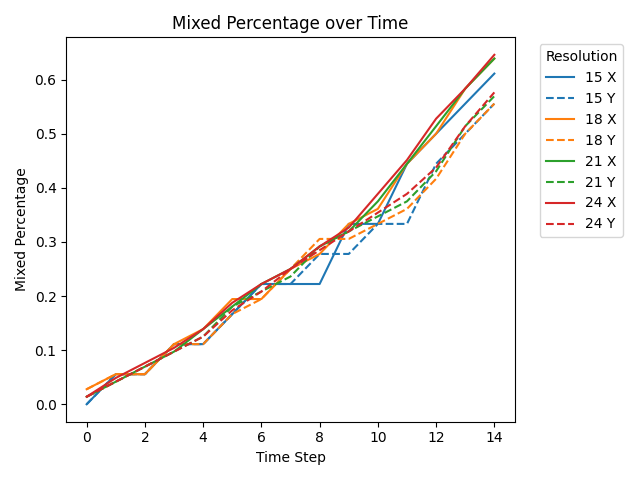

In [12]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure()
for i,(ys_x,ys_y) in enumerate(zip(all_ys_x, all_ys_y)):

    plt.plot(times, ys_x, label=f'{resolutions[i]} X', linestyle='-', color=colors[i])
    plt.plot(times, ys_y, label=f'{resolutions[i]} Y', linestyle='--', color=colors[i])
    
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.title('Mixed Percentage over Time')
plt.ylabel('Mixed Percentage')
plt.xlabel('Time Step')
plt.tight_layout()
plt.show()

This approach produces results 10% to 20% lower than the z-orthogonal plane approach. Although it captures the general trend, it does not get enough samples to provide an accurate result. If all slices were not able to be sampled, a monte-carlo approach may perform better than simply sampling one slice. From the visualization, we can see where the slice misses the highest peaks becuase it happens to be in a valley.

<IPython.core.display.Javascript object>


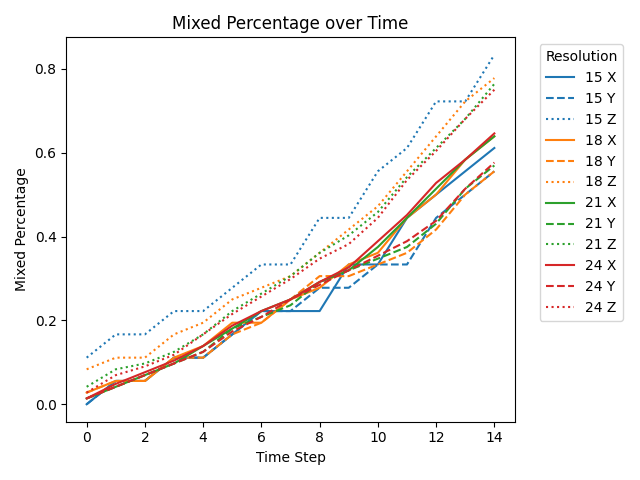

In [13]:
#####
# 5 #
#####

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plt.figure()
for i,(ys_x,ys_y) in enumerate(zip(all_ys_x, all_ys_y)):

    plt.plot(times, ys_x, label=f'{resolutions[i]} X', linestyle='-', color=colors[i])
    plt.plot(times, ys_y, label=f'{resolutions[i]} Y', linestyle='--', color=colors[i])
    plt.plot(times, all_ys[i], label=f'{resolutions[i]} Z', linestyle=':', color=colors[i])
    
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.title('Mixed Percentage over Time')
plt.ylabel('Mixed Percentage')
plt.xlabel('Time Step')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


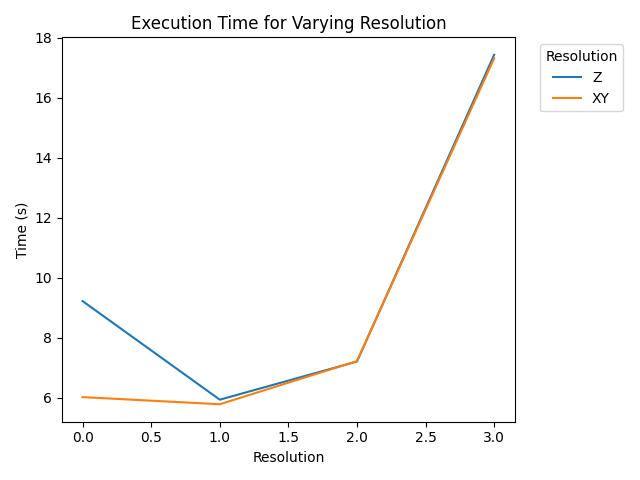

In [24]:
resolutions = [15, 18, 21, 24]
plt.figure()
plt.plot(resolutions, all_ys_times, label='Z')
plt.plot(resolutions, all_ys_xy_times, label='XY')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.title('Execution Time for Varying Resolution')
plt.ylabel('Time (s)')
plt.xlabel('Resolution')
plt.tight_layout()
plt.show()

The z-orthogonal plane approach is more accurate and operates in the same time. It is likley that these timings are dominated by loading the data. A more careful measurement could be taken to exclude the time involved in loading data.

## 6

![](Part2-6.png)

In [61]:
#####
# 7 #
#####

resolution = 27
times = list(range(15))

derived = dataset.read(max_resolution=resolution, time=times[0])
n = ceil(derived.shape[0]/15)

try:
    for time in times[1:]:
        data = dataset.read(max_resolution=resolution, time=time)

        for i in range(n):    
            x_slice = data[:,:,time*n+i]
            y_slice = data[:,time*n+i,:]

            derived[:,:,time*n+i] = y_slice
except:
    pass

derived.tofile('derived.raw')
print(derived.shape)

(288, 288, 288)


![](Part2-7.png)

This visualization helps to show the progression of the mixing over time. It is useful for seeing the rate at which the mixing layer grows.